In [1]:
import sys
sys.path.append('../')
#import functions
#exec(open('./functions.py').read())
%run functions.py
import demoji
#demoji.download_codes()

C:\Users\Annelie Schridde\AppData\Roaming\Python\Python38\site-packages\gensim\similarities\__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)
[nltk_data] Downloading package stopwords to C:\Users\Annelie
[nltk_data]     Schridde\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package vader_lexicon to C:\Users\Annelie
[nltk_data]     Schridde\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package punkt to C:\Users\Annelie
[nltk_data]     Schridde\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
def classify_bots(df):
    #collect all the account names related to bots and scripts
    names = []
    pat = r'(bot\s|script|bot_)'
    for name in df.name.unique():
        match = re.findall(pat, name, re.IGNORECASE) 
        if len(match) > 0:
            names.append(name)
    #look for a key words to identify a tweet related to bots and scripts
    pattern = r"(script|bot\s|bots\s|bot_|cook|cop^e|destroy|proxy)"
    df['bot'] = False
    for i, row in df.iterrows():
        match = re.findall(pattern, row.tweet, re.IGNORECASE) 
        if len(match) > 0 or row.isin(names)['name'] == True:
            df['bot'].loc[i] = True
    return df

In [32]:
#load labelled data (generated in file 2.preprocessing_en)
data = pickle.load(open('data_n_models/eng_df_labelled.pkl', "rb"))

#filter out bot reated data
data = classify_bots(data)
data = data[data['bot']==False]
data = data[data['keyword']=='zalando']
data = data.drop_duplicates(subset=['lemma'])
data.head()


C:\Users\Annelie Schridde\AppData\Roaming\Python\Python38\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
C:\Users\Annelie Schridde\AppData\Roaming\Python\Python38\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


,index,user_id,user_statuses,name,tweet,retweets,location,created,followers,is_user_verified,favorite_count,in_reply_to_status_id,keyword,language,clean,clean_vader,compound,lemma,bot
0,0,819101311715131392,77,Ali09685762,@Zalando give me my money you owe me!!!,0,,07-Mar-2021,6,False,0.0,NaN,zalando,en,money owe,give money you owe me!!!,0.0000,money owe,False
1,1,1189512849472643072,105,Labellerr1,#VirtualStyling and try-on increases the conve...,0,chandigarh,06-Mar-2021,18,False,0.0,NaN,zalando,en,virtualstyling try increases conversion rate l...,VirtualStyling and try-on increases the conver...,0.7650,virtualstyle try increase conversion rate larg...,False
3,3,1125728513666048000,9604,DommeLineCoUk,@missbellalugosi @Zalando Problem starts at Ad...,0,,06-Mar-2021,2193,False,1.0,1.368196e+18,zalando,en,problem starts adidas selling latex websites,Problem starts Adidas. They're selling latex t...,-0.4019,problem start adida sell latex website,False
4,4,2614256724,35470,medboyUK,@missbellalugosi @Zalando Welcome to my world ...,0,"West Midlands, UK",06-Mar-2021,2503,False,1.0,1.368196e+18,zalando,en,welcome world sneering disdain,Welcome world sneering and disdain!,-0.1007,welcome world sneer disdain,False
5,5,978410484155199488,1549,missbellalugosi,Hey @Zalando these clothes are not made of la...,0,GERMANY / UK / USA,06-Mar-2021,13827,False,17.0,NaN,zalando,en,hey clothes latex plastic latex rubber stitche...,"Hey these clothes are not made latex, they are...",0.5362,hey clothe latex plastic latex rubber stitch r...,False


In [4]:
for i, value in data[10:20].lemma.iteritems():
    print(i, value)

12 send delivery paper bag
13 order eventually thing happen expectation feed information whomever concerned zalando
14 hey order product web shop item " fast delivery " suppose arrive today unfortunately ship parcel time happen sad
15 zalando think big pregnant suggest lovely maternity clothe ️ ️ ️ ️ ️ ️ ️ thank love ️ ️ ️ ️
16 think belong sport shoe section
17 new redezign circularity pilot product product pilot equip digital tag save product datum scan able discover product history digital product site ️ ️
18 zalando ride cargo bike delivery service netherland
19 order ship able provide status update
20 check new cto cto podcast format dedicate impactful tech in episode victoria schmierer share story implement pre own give new life clothe ecommerce sustainability reuse rewear
21 stay informed circular csnew energylabel come force march help consumer cut energy bill footprint zircle wardrobe future list ️ circulareconomy sdg


# clustering with LatentDirichletAllocation

https://ourcodingclub.github.io/tutorials/topic-modelling-python/

### Working with bot-filtered, zalando data. Looking at only 1000 tweets to get a first glimpse

In [33]:
# new try with only nouns
df = list(data['lemma'])

C:\Users\Annelie Schridde\AppData\Roaming\Python\Python38\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [34]:
# Extracting the nouns from the text data 
from nltk.tag import pos_tag
from nltk.tokenize import word_tokenize
# Tokenize
from nltk.tokenize import RegexpTokenizer
tokenizer = RegexpTokenizer(r'\w+')
import nltk
nltk.download('averaged_perceptron_tagger')
data = data.iloc[0:1000]


C:\Users\Annelie Schridde\AppData\Roaming\Python\Python38\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\Annelie Schridde\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [35]:
data['tokens'] = data['lemma'].apply(lambda x: tokenizer.tokenize(x.lower()))
noun= []
for row in data['tokens']:
    noun.append([word for word,pos in pos_tag(row) if pos == 'NN'])

C:\Users\Annelie Schridde\AppData\Roaming\Python\Python38\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [36]:
# Create bigrams
# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
bigram = gensim.models.Phrases(noun, min_count=5, threshold=100)
bigram_mod = gensim.models.phrases.Phraser(bigram)

C:\Users\Annelie Schridde\AppData\Roaming\Python\Python38\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [37]:
def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

C:\Users\Annelie Schridde\AppData\Roaming\Python\Python38\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [38]:
words = make_bigrams(noun)

C:\Users\Annelie Schridde\AppData\Roaming\Python\Python38\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [39]:
# Step 1: create dicationary and corpus for topic modeling

# Create Dictionary
id2word = corpora.Dictionary(words)

# Create Corpus
texts = words

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1])
id2word[0]

[[(0, 1), (1, 1)]]
C:\Users\Annelie Schridde\AppData\Roaming\Python\Python38\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


'money'

In [40]:
# Define the optimal number of topics
def compute_coherence_values(dictionary, corpus, texts, limit, start=5, step=5):

    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=num_topics, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

C:\Users\Annelie Schridde\AppData\Roaming\Python\Python38\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [41]:
# Can take a long time to run (!!!)
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=words, start=5, limit=35, step=5)

C:\Users\Annelie Schridde\AppData\Roaming\Python\Python38\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


C:\Users\Annelie Schridde\AppData\Roaming\Python\Python38\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


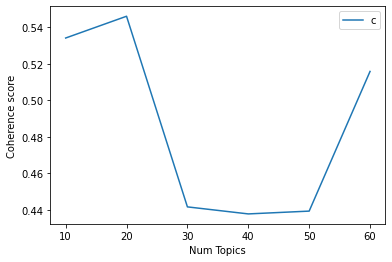

In [61]:
# Show graph
limit=70; start=10; step=10;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [65]:
## Step 2: build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=20, 
                                           random_state=40,
                                           update_every=1, # how often the model parameters should be updated
                                           chunksize=100, # number of texts to be used in each training chunk
                                           passes=10, # total number of training passes
                                           alpha='auto',
                                           per_word_topics=True)

C:\Users\Annelie Schridde\AppData\Roaming\Python\Python38\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [66]:
# Visualize the topics
import pyLDAvis
import pyLDAvis.gensim_models  # don't skip this


C:\Users\Annelie Schridde\AppData\Roaming\Python\Python38\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [67]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model, corpus, id2word)
vis

C:\Users\Annelie Schridde\AppData\Roaming\Python\Python38\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
12     0.458865  0.026681       1        1  31.200127
7      0.017669 -0.305285       2        1   8.146955
14    -0.003346  0.049532       3        1   6.866152
16    -0.008356 -0.049047       4        1   6.495505
2     -0.006398  0.036948       5        1   6.192569
8     -0.012328  0.034618       6        1   5.638005
17    -0.016992 -0.000221       7        1   4.702185
15    -0.024043  0.024050       8        1   4.337114
9     -0.024523  0.024101       9        1   4.261141
19    -0.025912  0.020849      10        1   3.880745
3     -0.029709  0.021763      11        1   3.375652
4     -0.030488  0.019135      12        1   2.790973
11    -0.035771  0.015107      13        1   2.387667
1     -0.031272  0.017862      14        1   2.077585
6     -0.035235  0.015280      15        1   2.008954
18    -0.036662  0.014057      16        1   1.951118
0     -0.038684  0.009925      17        1   1.299514
5     -0.038437  0.011180      18        1   1.254307
13    -0.039196  0.008557      19        1   0.753330
10    -0.039181  0.004907      20        1   0.380400, topic_info=         Term         Freq        Total Category  logprob  loglift
74    zalando  1369.000000  1369.000000  Default  30.0000  30.0000
198   fashion   108.000000   108.000000  Default  29.0000  29.0000
172    market    62.000000    62.000000  Default  28.0000  28.0000
234   account    49.000000    49.000000  Default  27.0000  27.0000
41       time    63.000000    63.000000  Default  26.0000  26.0000
..        ...          ...          ...      ...      ...      ...
25   material     0.011122     2.794089  Topic20  -7.6049   0.0454
26       mold     0.011122     1.063802  Topic20  -7.6049   1.0110
27    plastic     0.011122     1.063802  Topic20  -7.6049   1.0110
28   retailer     0.011122    28.379178  Topic20  -7.6049  -2.2728
29     rubber     0.011122     1.683660  Topic20  -7.6049   0.5519

[722 rows x 6 columns], token_table=      Topic      Freq         Term
term                              
234      14  0.979029      account
13       17  0.574482        adida
131       2  0.850682       advice
296      15  0.784632          air
356      11  0.902255  application
...     ...       ...          ...
64        3  0.984439         year
280      13  0.840659          zal
74        1  0.999339      zalando
350       5  0.764110       zappos
129      11  0.662798       zircle

[226 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[13, 8, 15, 17, 3, 9, 18, 16, 10, 20, 4, 5, 12, 2, 7, 19, 1, 6, 14, 11])

In [68]:
def format_topics_sentences(ldamodel=None, corpus=corpus, texts=data):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list            
        # print(row)
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=words)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
df_dominant_topic

C:\Users\Annelie Schridde\AppData\Roaming\Python\Python38\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,19.0,0.2998,"sustainability, money, check, talk, consumer, ...","[money, owe]"
1,1,8.0,0.5247,"stock, s, pair, help, dunk, datum, world, disc...","[try, increase, conversion, rate, return, rate..."
2,2,0.0,0.3076,"start, performance, tell, refund, choose, adid...","[problem, start, adida, website]"
3,3,8.0,0.3164,"stock, s, pair, help, dunk, datum, world, disc...","[world, sneer, disdain]"
4,4,15.0,0.5756,"market, cop, bag, discount, snipe, fit, love, ...","[hey, clothe, latex, plastic, latex, rubber, s..."
...,...,...,...,...,...
995,995,12.0,0.3487,"zalando, order, today, thing, expectation, idk...","[zalando, drop, start]"
996,996,12.0,0.4242,"zalando, order, today, thing, expectation, idk...","[zalando, thank]"
997,997,12.0,0.6408,"zalando, order, today, thing, expectation, idk...","[zalando, order, arrive]"
998,998,13.0,0.2836,"ship, update, status, provide, omah, burna, is...","[ship, worldwide]"


In [69]:
# Build topic column for test set
Topics = df_dominant_topic['Dominant_Topic']
data['Topics'] = Topics

C:\Users\Annelie Schridde\AppData\Roaming\Python\Python38\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
